In [1]:
"""
If you want use VOC Dataset for plate's background,
Please run this code. (Linux)
"""

import sys
import os

if sys.platform  == "linux":
    if not os.path.isfile("./VOCtrainval_11-May-2012.tar"):
        %%capture
        !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
        !tar -xvf ./VOCtrainval_11-May-2012.tar
        
elif sys.platform  == "windows":
    """
    Visit https://pjreddie.com/projects/pascal-voc-dataset-mirror/
    """
    pass

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from PIL import (
    Image,
    ImageDraw,
    ImageFont,
    ImageFilter
)
from abc import *

import cv2
import glob
import random
import matplotlib.pyplot as plt

%matplotlib inline

In [1331]:
def generate_rand_hex(
    _min: int=0,
    _max: int=255,
    size: int=3
):
    _hex = ""
    for _ in range(size):
        hex_val = hex(random.randint(_min, _max))[2:]
        if len(hex_val) == 1: hex_val = "0" + hex_val
        _hex += hex_val
        
    return _hex

def auto_font(font_path, image_size, text, margin=0):
    canvas = Image.new('RGB', image_size)
    font_size = 1
    font = ImageFont.truetype(font_path, font_size)

    while (font.getsize(text)[0] < canvas.size[0]) and (font.getsize(text)[1] < canvas.size[1]):
        font_size += 1
        font = ImageFont.truetype(font_path, font_size)

    return ImageFont.truetype(font_path, font_size - margin)

def normalize(image):
    img = np.array(image)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    dilated = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
    median = cv2.medianBlur(dilated, 15)
    diff = 255 - cv2.subtract(median, img)

    return cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX)


class LicensePlate:
    
    def __init__(self, opt):
        self.opt = opt
        self.plate_type = opt["plate_type"]
        self.register = None
        self.fonts = None
        
    def __str__(self):
        return self.plate_type
    
    def build_font_list(self):
        if self.opt["font_dir"][-1] == "/": font_list = glob.glob(self.opt["font_dir"] + "*")
        else: font_list = glob.glob(self.opt["font_dir"] + "/*")
            
        self.fonts = list()
        for font in font_list:
            self.fonts.append(auto_font(
                font, (self.opt["width"], self.opt["height"]),
                self.register, margin=self.opt["font_margin"]))
            
    def generate_text(self) -> Image:
        self.background = (
            random.randint(self.opt["bg_r_min"], self.opt["bg_r_max"]),
            random.randint(self.opt["bg_g_min"], self.opt["bg_g_max"]),
            random.randint(self.opt["bg_b_min"], self.opt["bg_b_max"]))
        
        image = Image.new(self.opt["image_mode"], (self.opt["width"], self.opt["height"]), self.background)
        canvas = ImageDraw.Draw(image)
        
        self.register = ""
        for c in self.plate_type:
            if c == 'n': self.register += str(random.choice(self.opt["n_list"]))
            elif c == 'c': self.register += str(random.choice(self.opt["c_list"]))
            elif c == ' ': self.register += ' '
            else: raise ValueError(
                "Unknown layout value %s, please use \'n', \'c', \' ' only" % c)
        
        if self.fonts == None:
            self.build_font_list()       
            
        canvas.text((0, 0), self.register,
                    font=random.choice(self.fonts),
                    fill="#%s" % generate_rand_hex(self.opt["text_color_min"], self.opt["text_color_max"]))
        
        return image
    
        
class LicensePlateBuilder:
    
    def __init__(self, opt):
        self.opt = opt
        self.lp = LicensePlate(opt)
        self.image = None
        
    def generate_text(self):
        self.image = self.lp.generate_text()
        return self.image
            
    def rotate(self):
        self.image = self.image.rotate(
            random.randint(self.opt["rotate_degree_min"], self.opt["rotate_degree_max"]),
            fillcolor=self.lp.background)
        return self.image
        
    def translate(self):
        self.image = self.image.rotate(
            0, fillcolor=self.lp.background,
            translate=(
                random.randint(self.opt["translate_x_min"], self.opt["translate_x_max"]),
                random.randint(self.opt["translate_y_min"], self.opt["translate_y_max"])))
        return self.image
        
    def darken(self):
        factor = (random.random() % (self.opt["darken_max"] - self.opt["darken_min"]) + self.opt["darken_min"]) * 255
        shadow = np.ones((self.opt["height"], self.opt["width"]), dtype=np.float) * factor
        
        if len(self.opt["image_mode"]) > 1:
            shadow = np.repeat(shadow[:, :, np.newaxis], len(self.opt["image_mode"]), axis=-1)

        self.image -= shadow
        self.image[self.image<0] = 0
        
        self.image = Image.fromarray(self.image.astype(np.uint8))
        return self.image
    
    def lighten(self):
        pos_x = random.randint(0, self.opt["width"])
        pos_y = random.randint(0, self.opt["height"])

        light = random.uniform(self.opt["lighten_min"], self.opt["lighten_max"])

        w_l = np.linspace(0, light, num=pos_x)
        w_r = np.array(list(reversed(np.linspace(0, light, num=self.opt["width"] - pos_x))))
        light_w = np.concatenate([w_l, w_r])

        h_l = np.linspace(0, light, num=pos_y)
        h_r = np.array(list(reversed(np.linspace(0, light, num=self.opt["height"] - pos_y))))
        light_h = np.concatenate([h_l, h_r])

        light = np.sqrt(np.outer(light_h, light_w))  * 255

        if len(self.opt["image_mode"]) > 1:
            light = np.repeat(light[:, :, np.newaxis], len(self.opt["image_mode"]), axis=-1)

        self.image += light
        self.image[self.image>255] = 255
        
        self.image = Image.fromarray(self.image.astype(np.uint8))
        return self.image
    
    def blur(self):
        self.image = self.image.filter(
            ImageFilter.GaussianBlur(
                radius=random.randint(self.opt["blur_min"], self.opt["blur_max"])))
        return self.image
    
    def salt_and_pepper(self):
        img = np.array(self.image)
        snp = np.random.random(img.shape)
        
        img[snp>=(1-self.opt["snp_threshold"])] = self.opt["snp_max_value"]
        img[snp<=self.opt["snp_threshold"]] = self.opt["snp_min_value"]

        self.image = Image.fromarray(img.astype(np.uint8))
        return self.image
    
    def rectangle(self):
        if self.opt["image_mode"] != "RGB":
            raise ValueError("only RGB mode can draw rectangle (not implemented)")
            
        line_width = random.randint(self.opt["rect_line_width_min"], self.opt["rect_line_width_max"])
        print(line_width)
        pad_x = random.randint(self.opt["rect_pad_x_min"], self.opt["rect_pad_x_max"]) + line_width
        pad_y = random.randint(self.opt["rect_pad_y_min"], self.opt["rect_pad_y_max"]) + line_width
        outline_color = (
            random.randint(self.opt["rect_color_min"], self.opt["rect_color_max"]),
            random.randint(self.opt["rect_color_min"], self.opt["rect_color_max"]),
            random.randint(self.opt["rect_color_min"], self.opt["rect_color_max"]))

        R, G, B = self.lp.background
        bg_val = (R + G + B) // 3
        w, h = self.image.size
        
        canvas = ImageDraw.Draw(self.image)
        arr = np.array(self.image)
        
        mask_channel = np.mean(arr, axis=-1).astype(np.long)
        
        if np.max(mask_channel) == bg_val:
            width_mask = np.mean(np.mean(arr[:, :, :], axis=-1), axis=0).astype(np.long)
            height_mask = np.mean(np.mean(arr[:, :, :], axis=-1), axis=1).astype(np.long)

            width_mask[width_mask<bg_val] = 1
            width_mask[width_mask>=bg_val] = 0

            height_mask[height_mask<bg_val] = 1
            height_mask[height_mask>=bg_val] = 0

        elif np.min(mask_channel) == bg_val:
            width_mask = np.mean(np.mean(arr[:, :, :], axis=-1), axis=0).astype(np.long)
            height_mask = np.mean(np.mean(arr[:, :, :], axis=-1), axis=1).astype(np.long)

            width_mask[width_mask<=bg_val] = 0
            width_mask[width_mask>bg_val] = 1

            height_mask[height_mask<=bg_val] = 0
            height_mask[height_mask>bg_val] = 1
            
        left = np.argmax(width_mask)
        right = w - np.argmax(np.flip(width_mask))

        top = np.argmax(height_mask)
        bottom = h - np.argmax(np.flip(height_mask))

        canvas.rectangle(
            [(left - pad_x, top - pad_y), (right + pad_x, bottom + pad_y)],
            outline=outline_color, width=line_width)
        return self.image
    
    def binarize(self):
        mode = self.opt["image_mode"]
        img = normalize(self.image)
        
        if mode != "L":
            img = np.mean(img, axis=-1).astype('uint8')

        img[img > self.opt["binarize_threshold"]] = 255
        img[img < self.opt["binarize_threshold"]] = 0
        
        self.image = Image.fromarray(img.astype('uint8'), "L")
        return self.image
    
    
class LicensePlateGenerator:
    
    def __init__(self):
        self.builder = None
        
    def generate_license_plate(
        self,
        builder: LicensePlateBuilder,
        execute_fn:list=None,
        except_fn:list=None
    ):
        self.builder = builder
        steps = (
            builder.generate_text,
            builder.translate,
            builder.rectangle,
            builder.rotate, 
            builder.salt_and_pepper,
            builder.darken,
            builder.lighten,
            builder.blur,
            builder.binarize
        )
        if (execute_fn is None) & (except_fn is None):
            raise ValueError("one of execute_fn or except_fn should be passed")
            
        if execute_fn is None:
            for func in steps:
                if func.__name__ not in except_fn:
                    image = func()
                
        if except_fn is None:
            for func in steps:
                if func.__name__ in execute_fn:
                    image = func()
            
        return image

In [1332]:
n_list = list(str(i) for i in range(10))
c_list = [    # After 1996
    # 자가용
    '가', '나', '다', '라', '마',
    '거', '너', '더', '러', '머', '버', '서', '어', '저', 
    '고', '노', '도', '로', '모', '보', '소', '오', '조',
    '구', '누', '두', '루', '무', '부', '수', '우', '주',
    
    # 사업용
    '바', '사', '아', '자',
    
    # 군용
    '공', '해', '육', '합',
    
    # 기타
    '허', '하', '호', '배'
]
        
opt = {
    "width"       : 240,
    "height"      : 80,
    "font_dir"    : "./fonts",
    "font_margin" : 10,
    "n_list"      : n_list,
    "c_list"      : c_list,
    "image_mode"  : "RGB",
    "plate_type"  : "nnc nnnn"
}

random_opt = {
    "bg_r_min"            : 0,
    "bg_r_max"            : 255,
    "bg_g_min"            : 0,
    "bg_g_max"            : 255,
    "bg_b_min"            : 0,
    "bg_b_max"            : 255,
    "text_color_min"      : 0,
    "text_color_max"      : 255,
    "text_pad_x_min"      : 0,
    "text_pad_x_max"      : 20,
    "text_pad_y_min"      : 0,
    "text_pad_y_max"      : 20,
    "rect_pad_x_min"      : 0,
    "rect_pad_x_max"      : 10,
    "rect_pad_y_min"      : 0,
    "rect_pad_y_max"      : 10,
    "rect_color_min"      : 0,
    "rect_color_max"      : 255,
    "rect_line_width_min" : 0,
    "rect_line_width_max" : 10,
    "rotate_degree_min"   : -10,
    "rotate_degree_max"   : 10,
    "translate_x_min"     : 0,
    "translate_x_max"     : 10,
    "translate_y_min"     : 0,
    "translate_y_max"     : 10,
    "darken_min"          : 0.0,
    "darken_max"          : 1.0,
    "lighten_min"         : 0.0,
    "lighten_max"         : 1.0,
    "blur_min"            : 0,
    "blur_max"            : 2,
    "snp_threshold"       : 0.005,
    "snp_min_value"       : 0,
    "snp_max_value"       : 255,
    "binarize_threshold"  : 200
}

opt.update(random_opt)

In [1356]:
standard_opt = opt.copy()

standard_opt["bg_r_min"] = 100
standard_opt["bg_g_min"] = 100
standard_opt["bg_b_min"] = 100

standard_opt["text_color_max"] = 10
standard_opt["darken_max"] = 0.3

standard_opt["rect_line_width_min"] = 0
standard_opt["rect_line_width_max"] = 50

standard_opt["rect_color_min"] = 10
standard_opt["rect_color_max"] = 50

standard_opt["rect_pad_x_min"] = 5
standard_opt["rect_pad_x_max"] = 10
standard_opt["rect_pad_y_min"] = 5
standard_opt["rect_pad_y_max"] = 10

standard_opt["blur_max"] = 1

standard_builder = LicensePlateBuilder(standard_opt)

In [1357]:
lpgen = LicensePlateGenerator()

33


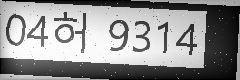

In [1387]:
lpgen.generate_license_plate(standard_builder, except_fn=[
    "binarize"
]).convert("L")

In [1388]:
old_opt = opt.copy()

old_opt["plate_type"] = "nnnn"

old_opt["bg_r_min"] = 40
old_opt["bg_r_max"] = 60
old_opt["bg_g_min"] = 80
old_opt["bg_g_max"] = 120
old_opt["bg_b_min"] = 40
old_opt["bg_b_max"] = 60

old_opt["translate_x_min"] = 10

old_opt["text_color_min"] = 200
old_opt["text_color_max"] = 240
old_opt["darken_max"] = 0.3

old_opt["blur_max"] = 1

old_builder = LicensePlateBuilder(old_opt)

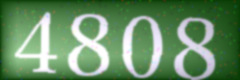

In [1437]:
lpgen.generate_license_plate(old_builder, except_fn=[
    "rectangle",
    "binarize"
])